<a href="https://colab.research.google.com/github/NiZhLi/ML-homework/blob/main/%E6%B7%B1%E5%BA%A6%E7%94%9F%E6%88%90%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業一

In [ ]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html

    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels

    # Not sure why, but yann lecun's website does no longer support
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'

    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)

    return train_features, train_labels, test_features, test_labels


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))  # 範圍 [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# 損失函數：重建誤差 + KL divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def train_vae(train_features, test_features, epochs=10, batch_size=128, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 建立 Dataset / DataLoader
    train_data = torch.tensor(train_features, dtype=torch.float32).view(-1, 784)
    test_data = torch.tensor(test_features, dtype=torch.float32).view(-1, 784)
    train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)

    # 初始化模型
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 訓練迴圈
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

    # 測試並顯示重建效果
    model.eval()
    with torch.no_grad():
        test_batch = test_data[:8].to(device)
        recon_batch, _, _ = model(test_batch)

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(test_batch[i].cpu().view(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(recon_batch[i].cpu().view(28, 28), cmap="gray")
        axes[1, i].axis("off")
    plt.show()


Done.
Done.
Done.
Done.
Epoch 1, Avg Loss: 165.4803
Epoch 2, Avg Loss: 122.5858
Epoch 3, Avg Loss: 115.3563
Epoch 4, Avg Loss: 112.2845
Epoch 5, Avg Loss: 110.5022
Epoch 6, Avg Loss: 109.3759
Epoch 7, Avg Loss: 108.4941
Epoch 8, Avg Loss: 107.8451
Epoch 9, Avg Loss: 107.3995
Epoch 10, Avg Loss: 106.9695


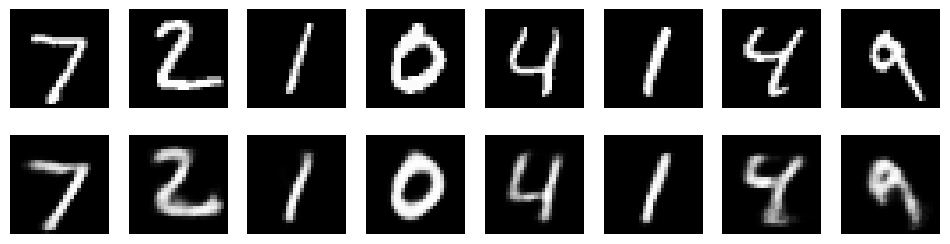

In [ ]:
train_features, train_labels, test_features, test_labels = get_mnist()
train_vae(train_features, test_features, epochs=10)

# 作業二

## VAE

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.24MB/s]


Epoch [1/30] Loss: 165.6817
Epoch [2/30] Loss: 121.8054
Epoch [3/30] Loss: 114.8626
Epoch [4/30] Loss: 111.9616
Epoch [5/30] Loss: 110.1205
Epoch [6/30] Loss: 108.9645
Epoch [7/30] Loss: 108.1110
Epoch [8/30] Loss: 107.4610
Epoch [9/30] Loss: 106.8871
Epoch [10/30] Loss: 106.4715
Epoch [11/30] Loss: 106.1059
Epoch [12/30] Loss: 105.7801
Epoch [13/30] Loss: 105.5475
Epoch [14/30] Loss: 105.2672
Epoch [15/30] Loss: 105.0512
Epoch [16/30] Loss: 104.8593
Epoch [17/30] Loss: 104.6260
Epoch [18/30] Loss: 104.4972
Epoch [19/30] Loss: 104.3295
Epoch [20/30] Loss: 104.2407
Epoch [21/30] Loss: 104.0871
Epoch [22/30] Loss: 103.9238
Epoch [23/30] Loss: 103.7849
Epoch [24/30] Loss: 103.7048
Epoch [25/30] Loss: 103.5804
Epoch [26/30] Loss: 103.4759
Epoch [27/30] Loss: 103.4056
Epoch [28/30] Loss: 103.2898
Epoch [29/30] Loss: 103.1843
Epoch [30/30] Loss: 103.1419


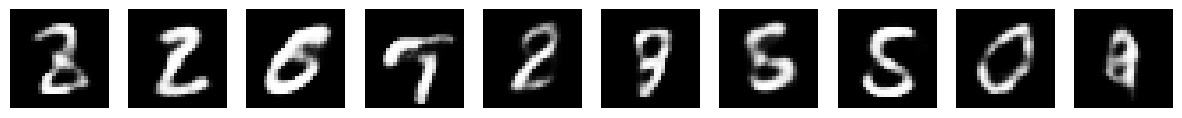

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),  # 轉為 tensor (0~1)
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== VAE Model ==========
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ========== Loss Function ==========
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch [{epoch}/{epochs}] Loss: {train_loss / len(train_loader.dataset):.4f}")

# ========== 生成影像 ==========
model.eval()
with torch.no_grad():
    z = torch.randn(10, 20).to(device)  # 從標準正態分布取樣
    samples = model.decode(z).cpu().view(-1, 1, 28, 28)

# 畫出 10 張隨機影像
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(samples[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.show()


## GAN

Epoch [1/30]  Loss D: 0.3273, Loss G: 1.4967
Epoch [2/30]  Loss D: 0.5485, Loss G: 3.1309
Epoch [3/30]  Loss D: 0.6237, Loss G: 5.4888
Epoch [4/30]  Loss D: 0.3461, Loss G: 4.0478
Epoch [5/30]  Loss D: 0.6434, Loss G: 0.4086
Epoch [6/30]  Loss D: 0.2127, Loss G: 2.0082
Epoch [7/30]  Loss D: 0.3308, Loss G: 3.6673
Epoch [8/30]  Loss D: 0.2963, Loss G: 1.9299
Epoch [9/30]  Loss D: 0.1841, Loss G: 2.9166
Epoch [10/30]  Loss D: 0.2170, Loss G: 2.0011
Epoch [11/30]  Loss D: 0.2657, Loss G: 2.2948
Epoch [12/30]  Loss D: 0.2003, Loss G: 2.2353
Epoch [13/30]  Loss D: 0.5317, Loss G: 4.5382
Epoch [14/30]  Loss D: 0.3111, Loss G: 1.7656
Epoch [15/30]  Loss D: 0.4015, Loss G: 2.2370
Epoch [16/30]  Loss D: 0.3385, Loss G: 1.7224
Epoch [17/30]  Loss D: 0.3833, Loss G: 1.3480
Epoch [18/30]  Loss D: 0.4228, Loss G: 1.4350
Epoch [19/30]  Loss D: 0.4753, Loss G: 1.8591
Epoch [20/30]  Loss D: 0.4170, Loss G: 1.7245
Epoch [21/30]  Loss D: 0.5025, Loss G: 0.8342
Epoch [22/30]  Loss D: 0.4527, Loss G: 1.38

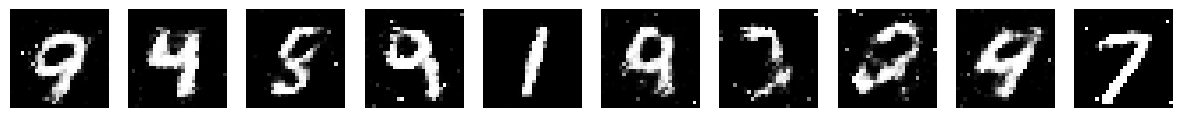

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 將 MNIST 正規化到 [-1, 1]
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== Generator ==========
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden_dim=256, img_dim=28*28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, img_dim),
            nn.Tanh()  # 輸出範圍 [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# ========== Discriminator ==========
class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # 輸出真假機率
        )

    def forward(self, x):
        return self.model(x)

# ========== 初始化 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Loss & Optimizer
criterion = nn.BCELoss()
lr = 2e-4
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ========== Training ==========
epochs = 30
for epoch in range(1, epochs+1):
    for real, _ in train_loader:
        real = real.view(-1, 28*28).to(device)
        batch_size = real.size(0)

        ### 訓練判別器 ###
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator(noise)

        disc_real = discriminator(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))  # 真圖 label=1

        disc_fake = discriminator(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))  # 假圖 label=0

        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### 訓練生成器 ###
        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))  # 生成器希望騙過 D → label=1

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{epochs}]  Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

# ========== 生成影像 ==========
generator.eval()
with torch.no_grad():
    z = torch.randn(10, z_dim).to(device)
    samples = generator(z).cpu().view(-1, 1, 28, 28)

# 顯示 10 張隨機影像
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(samples[i].squeeze()*0.5+0.5, cmap="gray")  # 轉回 [0,1]
    axes[i].axis("off")
plt.show()


## cGAN

Epoch [1/30] Loss D: 0.3098, Loss G: 2.8375
Epoch [2/30] Loss D: 0.2903, Loss G: 2.2413
Epoch [3/30] Loss D: 0.3106, Loss G: 3.3844
Epoch [4/30] Loss D: 0.2636, Loss G: 3.1954
Epoch [5/30] Loss D: 0.5817, Loss G: 7.3992
Epoch [6/30] Loss D: 0.3000, Loss G: 1.9382
Epoch [7/30] Loss D: 0.3375, Loss G: 3.5798
Epoch [8/30] Loss D: 0.2436, Loss G: 3.3848
Epoch [9/30] Loss D: 0.2826, Loss G: 4.0361
Epoch [10/30] Loss D: 0.3890, Loss G: 1.5149
Epoch [11/30] Loss D: 0.3202, Loss G: 3.1729
Epoch [12/30] Loss D: 0.4138, Loss G: 1.4792
Epoch [13/30] Loss D: 0.3958, Loss G: 1.6504
Epoch [14/30] Loss D: 0.4331, Loss G: 2.7381
Epoch [15/30] Loss D: 0.4246, Loss G: 1.5212
Epoch [16/30] Loss D: 0.4205, Loss G: 2.6423
Epoch [17/30] Loss D: 0.4187, Loss G: 1.9681
Epoch [18/30] Loss D: 0.4963, Loss G: 2.1031
Epoch [19/30] Loss D: 0.4500, Loss G: 1.8180
Epoch [20/30] Loss D: 0.4813, Loss G: 1.2414
Epoch [21/30] Loss D: 0.5017, Loss G: 1.8820
Epoch [22/30] Loss D: 0.5302, Loss G: 1.6154
Epoch [23/30] Loss 

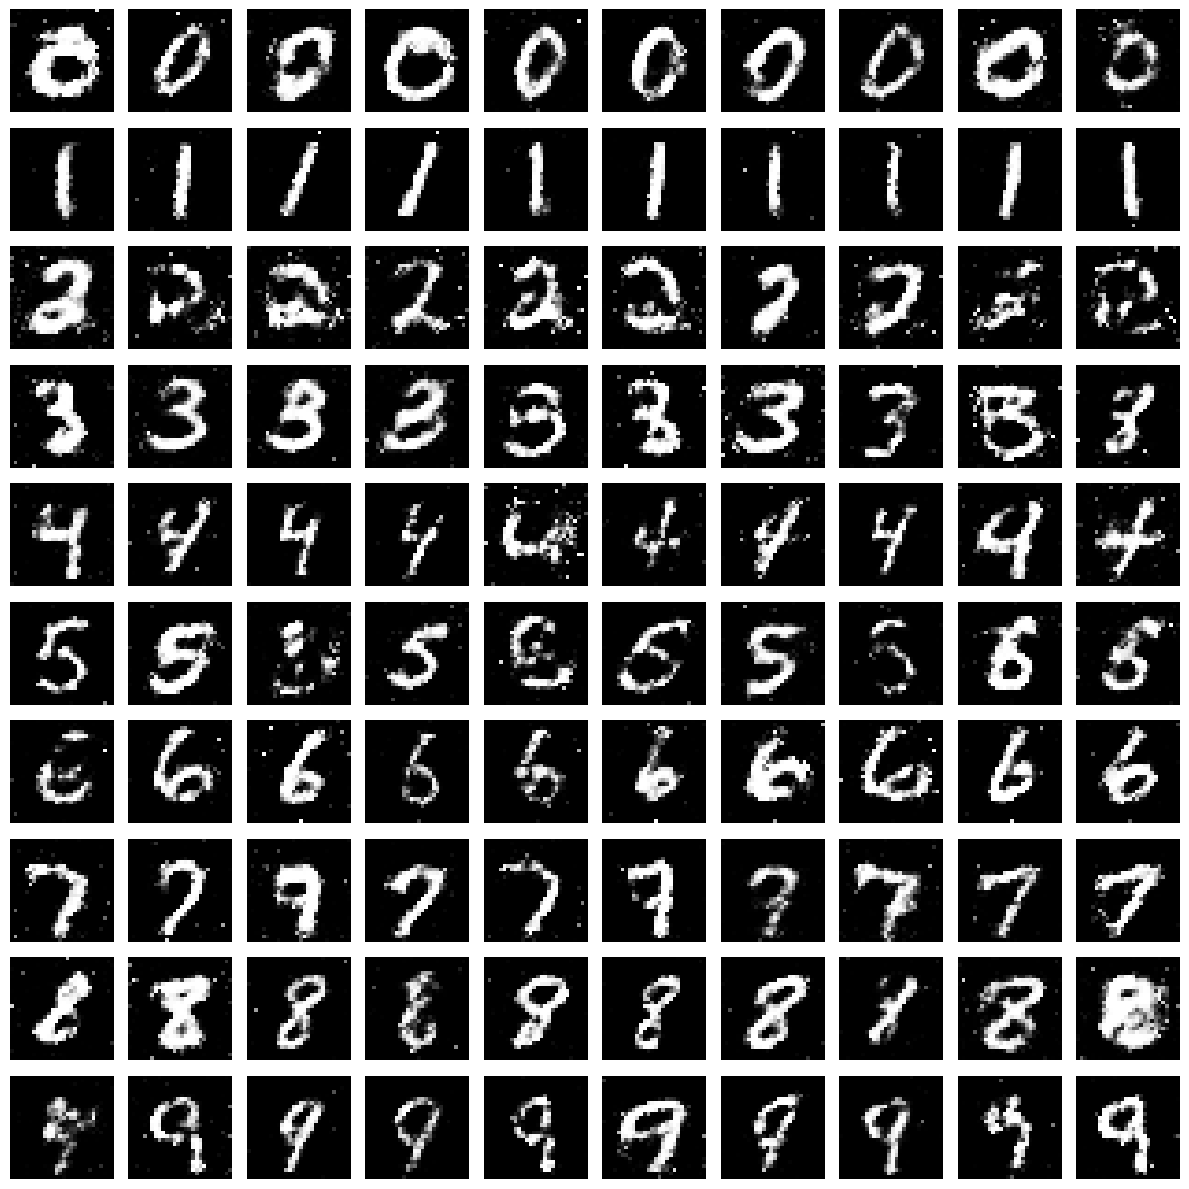

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1]
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== cGAN 模型 ==========
class Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=10, img_dim=28*28, hidden_dim=256):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # labels: one-hot
        x = torch.cat([z, labels], dim=1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_dim=28*28, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + num_classes, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat([img, labels], dim=1)
        return self.model(x)

# One-hot 編碼
def one_hot(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

# ========== 初始化 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 2e-4
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ========== Training ==========
epochs = 30
for epoch in range(1, epochs+1):
    for real, labels in train_loader:
        real = real.view(-1, 28*28).to(device)
        labels = one_hot(labels).to(device)
        batch_size = real.size(0)

        ### 訓練 Discriminator ###
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator(noise, labels)

        disc_real = discriminator(real, labels).view(-1)
        # label smoothing: 真樣本的 target 從 1.0 改為 0.9
        lossD_real = criterion(disc_real, torch.ones_like(disc_real) * 0.9)

        disc_fake = discriminator(fake.detach(), labels).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### 訓練 Generator ###
        output = discriminator(fake, labels).view(-1)
        lossG = criterion(output, torch.ones_like(output))  # 生成器希望判斷為真

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{epochs}] Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

# ========== 生成 0–9 各 10 張影像 ==========
generator.eval()
num_classes = 10
n_samples_per_class = 10
with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_class, z_dim).to(device)
    labels = torch.arange(num_classes).repeat_interleave(n_samples_per_class)
    labels = one_hot(labels, num_classes=num_classes).to(device)

    samples = generator(z, labels).cpu().view(-1, 1, 28, 28)

# ========== 畫 10×10 圖格 ==========
fig, axes = plt.subplots(num_classes, n_samples_per_class, figsize=(12, 12))
idx = 0
for i in range(num_classes):
    for j in range(n_samples_per_class):
        axes[i, j].imshow(samples[idx].squeeze()*0.5+0.5, cmap="gray")  # 轉回 [0,1]
        axes[i, j].axis("off")
        idx += 1
plt.tight_layout()
plt.show()


## Diffusion

In [ ]:
!pip install torchinfo

In [ ]:
import torch

print("GPU name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: Tesla T4 

Device is: cuda 

Total number of GPUs: 1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from torchvision.utils import make_grid
from tqdm import tqdm
from torchinfo import summary


# ========== (reference:randomaccess2023)this model will be delete after the course is done ============


transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)


training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output


ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

n_epochs = 20
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')




100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]
100%|██████████| 156/156 [00:15<00:00,  9.93it/s]


Epoch: 1/20	| Training loss: 0.0583 |   Test loss: 0.0298


100%|██████████| 156/156 [00:15<00:00,  9.87it/s]


Epoch: 2/20	| Training loss: 0.0277 |   Test loss: 0.0243


100%|██████████| 156/156 [00:16<00:00,  9.65it/s]


Epoch: 3/20	| Training loss: 0.0237 |   Test loss: 0.0216


100%|██████████| 156/156 [00:15<00:00,  9.84it/s]


Epoch: 4/20	| Training loss: 0.0213 |   Test loss: 0.0214


100%|██████████| 156/156 [00:16<00:00,  9.61it/s]


Epoch: 5/20	| Training loss: 0.0203 |   Test loss: 0.0187


100%|██████████| 156/156 [00:15<00:00,  9.76it/s]


Epoch: 6/20	| Training loss: 0.0192 |   Test loss: 0.0194


100%|██████████| 156/156 [00:16<00:00,  9.66it/s]


Epoch: 7/20	| Training loss: 0.0186 |   Test loss: 0.0180


100%|██████████| 156/156 [00:15<00:00,  9.81it/s]


Epoch: 8/20	| Training loss: 0.0182 |   Test loss: 0.0171


100%|██████████| 156/156 [00:15<00:00,  9.77it/s]


Epoch: 9/20	| Training loss: 0.0177 |   Test loss: 0.0170


100%|██████████| 156/156 [00:15<00:00,  9.82it/s]


Epoch: 10/20	| Training loss: 0.0174 |   Test loss: 0.0174


100%|██████████| 156/156 [00:15<00:00,  9.79it/s]


Epoch: 11/20	| Training loss: 0.0171 |   Test loss: 0.0178


100%|██████████| 156/156 [00:15<00:00,  9.83it/s]


Epoch: 12/20	| Training loss: 0.0168 |   Test loss: 0.0163


100%|██████████| 156/156 [00:15<00:00,  9.77it/s]


Epoch: 13/20	| Training loss: 0.0170 |   Test loss: 0.0165


 12%|█▏        | 110/937 [00:28<03:37,  3.79it/s]

In [ ]:
gen_imgs, _ = ddpm.ddpm_sampling(model, num_samples=10, channels=1, img_size=32)
gen_imgs = gen_imgs[:, :, 2:30, 2:30]

# 顯示
fig, axes = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    axes[i].imshow(gen_imgs[i].squeeze().cpu().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

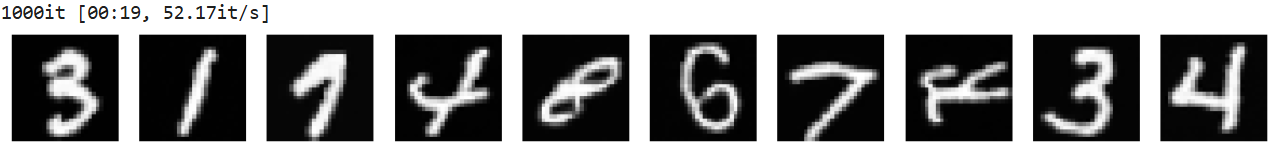
用其他帳號的colab跑出來的結果

# 作業三

In [17]:
!pip install scikit-learn

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anlgrbz/student-demographics-online-education-dataoulad")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-demographics-online-education-dataoulad' dataset.
Path to dataset files: /kaggle/input/student-demographics-online-education-dataoulad


In [4]:
studentInfo = pd.read_csv('/kaggle/input/student-demographics-online-education-dataoulad/studentInfo.csv')
studentVle = pd.read_csv('/kaggle/input/student-demographics-online-education-dataoulad/studentVle.csv')
studentAssessment = pd.read_csv('/kaggle/input/student-demographics-online-education-dataoulad/studentAssessment.csv')


In [5]:
# 不考量課程別及開課時間

studentVle['week'] = (studentVle['date'] // 7).astype(int)
studentAssessment['week'] = (studentAssessment['date_submitted'] // 7).astype(int)

# 每週點擊數
clicks_weekly = studentVle.groupby(['id_student', 'week'])['sum_click'].sum().reset_index(name='clicks')

# 每週作業提交次數(在每個課程模組中每個學生每禮拜作業有繳交的次數(沒成績算沒繳交))
submit_weekly = studentAssessment.groupby(['id_student', 'week'])['score'].count().reset_index(name='submit_cnt')

# 平均分數(看起來每周平均分數一樣)
score_avg = studentAssessment.groupby(['id_student', 'week'])['score'].mean().reset_index(name='avg_score_sofar')

# 合併三者
weekly = clicks_weekly.merge(submit_weekly, on=['id_student', 'week'], how='left')
weekly = weekly.merge(score_avg, on=['id_student', 'week'], how='left')

weekly['submit_cnt'] = weekly['submit_cnt'].fillna(0).astype(int)
weekly['avg_score_sofar'] = weekly['avg_score_sofar'].fillna(0)

# 點擊差分
weekly['clicks_diff1'] = weekly.groupby('id_student')['clicks'].diff().fillna(0).astype(int)

all_weeks = range(weekly['week'].min(), weekly['week'].max() + 1)
def fill_student_weeks(df):
    df = df.set_index('week').reindex(all_weeks, fill_value=0).reset_index()
    df['id_student'] = df['id_student'].iloc[0]
    return df

weekly_full = weekly.groupby('id_student').apply(fill_student_weeks).reset_index(drop=True)

/tmp/ipython-input-371919645.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_full = weekly.groupby('id_student').apply(fill_student_weeks).reset_index(drop=True)


In [7]:
# 去掉尚未開課的點擊率
weekly_full = weekly_full[weekly_full['week'] >= 0]

In [ ]:
weekly_full.head(40)

,week,id_student,clicks,submit_cnt,avg_score_sofar,clicks_diff1
4,0,6516,229,1,60.0,133
5,1,6516,42,1,48.0,-187
6,2,6516,79,1,63.0,37
7,3,6516,193,1,61.0,114
8,4,6516,69,1,77.0,-124
9,5,6516,34,0,0.0,-35
10,6,6516,10,0,0.0,-24
11,7,6516,93,0,0.0,83
12,8,6516,57,0,0.0,-36
13,9,6516,61,0,0.0,4


切分

In [8]:
students = weekly_full['id_student'].unique()
train_ids, test_ids = train_test_split(students, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

In [9]:
features = ['clicks', 'submit_cnt', 'avg_score_sofar', 'clicks_diff1']
def make_dataset(ids):
  seqs = []
  for sid in ids:
      data = weekly_full[weekly_full['id_student'] == sid].sort_values('week')
      X = data[features].values
      # 輸入過去 4 週，預測未來 2 週 clicks
      for i in range(len(X) - 6):
          seq_in = X[i:i+4]
          seq_out = data['clicks'].values[i+4:i+6]
          seqs.append((seq_in, seq_out))
  return seqs

train_data = make_dataset(train_ids)
val_data = make_dataset(val_ids)
test_data = make_dataset(test_ids)



Epoch 1/10: 100%|██████████| 7816/7816 [00:45<00:00, 173.32it/s]


Train Loss: 6897.4432


Epoch 2/10: 100%|██████████| 7816/7816 [00:44<00:00, 176.88it/s]


Train Loss: 6849.5358


Epoch 3/10: 100%|██████████| 7816/7816 [00:44<00:00, 176.47it/s]


Train Loss: 6846.0462


Epoch 4/10: 100%|██████████| 7816/7816 [00:44<00:00, 176.35it/s]


Train Loss: 6845.0956


Epoch 5/10: 100%|██████████| 7816/7816 [00:44<00:00, 174.84it/s]


Train Loss: 6842.5815


Epoch 6/10: 100%|██████████| 7816/7816 [00:43<00:00, 178.72it/s]


Train Loss: 6840.6905


Epoch 7/10: 100%|██████████| 7816/7816 [00:45<00:00, 173.22it/s]


Train Loss: 6838.8369


Epoch 8/10: 100%|██████████| 7816/7816 [00:44<00:00, 176.47it/s]


Train Loss: 6836.6510


Epoch 9/10: 100%|██████████| 7816/7816 [00:44<00:00, 177.36it/s]


Train Loss: 6835.2531


Epoch 10/10: 100%|██████████| 7816/7816 [00:43<00:00, 178.22it/s]


Train Loss: 6833.0464
Test MSE: 6325.0005


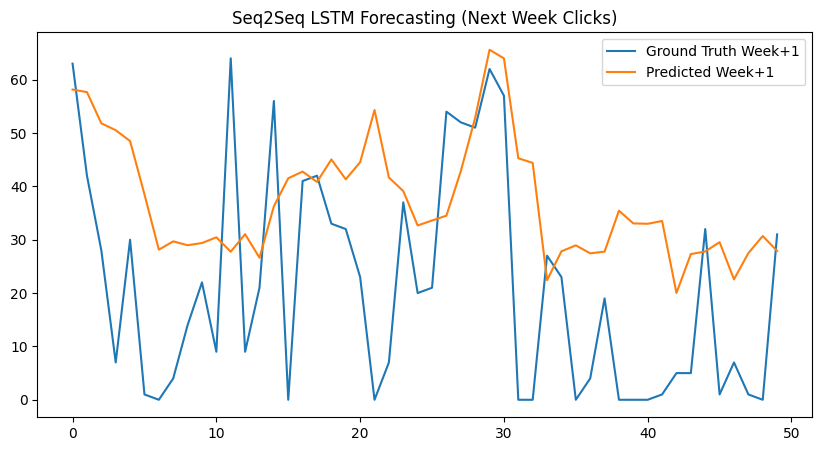

In [13]:
class SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_loader = DataLoader(SeqDataset(train_data), batch_size=128, shuffle=True)
val_loader = DataLoader(SeqDataset(val_data), batch_size=128)
test_loader = DataLoader(SeqDataset(test_data), batch_size=128)


class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_len=2, teacher_forcing_ratio=0.5):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(1, hidden_dim, batch_first=True)  # Decoder 只吃前一步 click
        self.fc = nn.Linear(hidden_dim, 1)
        self.output_len = output_len
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, x, y=None):

        batch_size = x.size(0)
        device = x.device
        _, (h, c) = self.encoder(x)

        # decoder 初始輸入
        dec_input = torch.zeros(batch_size, 1, 1, device=device)
        outputs = []

        for t in range(self.output_len):
            out, (h, c) = self.decoder(dec_input, (h, c))
            pred = self.fc(out)  # [batch, 1, 1]
            outputs.append(pred)

            # Teacher Forcing 機制
            use_teacher = y is not None and random.random() < self.teacher_forcing_ratio
            if use_teacher:
                dec_input = y[:, t].unsqueeze(1).unsqueeze(2)  # 用真實值
            else:
                dec_input = pred.detach()  # 用預測值

        outputs = torch.cat(outputs, dim=1).squeeze(-1)
        return outputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


for epoch in range(10):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x, y)  # 傳入 y 以啟用 teacher forcing
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(x)
    train_loss /= len(train_loader.dataset)
    print(f"Train Loss: {train_loss:.4f}")


model.eval()
preds, trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)  # 不傳 y
        preds.append(out.cpu().numpy())
        trues.append(y.cpu().numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)
mse = np.mean((preds - trues) ** 2)
print(f"Test MSE: {mse:.4f}")

# 可視化部分樣本
plt.figure(figsize=(10,5))
plt.plot(trues[:50, 0], label='Ground Truth Week+1')
plt.plot(preds[:50, 0], label='Predicted Week+1')
plt.legend()
plt.title("Seq2Seq LSTM Forecasting (Next Week Clicks)")
plt.show()


Device: cuda
Total sequences: 886516
Split sizes (train/val/test): 620534 88672 177310


Train Epoch 1/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.13it/s]


Epoch 1: Train loss=0.6203 (recon=0.6191 kld=1.1613) | Val loss=0.6655


Train Epoch 2/30: 100%|██████████| 4848/4848 [00:35<00:00, 137.99it/s]


Epoch 2: Train loss=0.6095 (recon=0.6083 kld=1.2318) | Val loss=0.6630


Train Epoch 3/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.23it/s]


Epoch 3: Train loss=0.6073 (recon=0.6062 kld=1.1169) | Val loss=0.6631


Train Epoch 4/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.82it/s]


Epoch 4: Train loss=0.6061 (recon=0.6051 kld=1.0287) | Val loss=0.6612


Train Epoch 5/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.16it/s]


Epoch 5: Train loss=0.6050 (recon=0.6041 kld=0.9687) | Val loss=0.6643


Train Epoch 6/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.60it/s]


Epoch 6: Train loss=0.6043 (recon=0.6034 kld=0.9051) | Val loss=0.6594


Train Epoch 7/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.44it/s]


Epoch 7: Train loss=0.6031 (recon=0.6023 kld=0.8811) | Val loss=0.6604


Train Epoch 8/30: 100%|██████████| 4848/4848 [00:35<00:00, 136.28it/s]


Epoch 8: Train loss=0.6023 (recon=0.6015 kld=0.8386) | Val loss=0.6604


Train Epoch 9/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.38it/s]


Epoch 9: Train loss=0.6014 (recon=0.6005 kld=0.8216) | Val loss=0.6616


Train Epoch 10/30: 100%|██████████| 4848/4848 [00:35<00:00, 137.25it/s]


Epoch 10: Train loss=0.6003 (recon=0.5995 kld=0.8031) | Val loss=0.6614


Train Epoch 11/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.99it/s]


Epoch 11: Train loss=0.5994 (recon=0.5986 kld=0.7997) | Val loss=0.6602


Train Epoch 12/30: 100%|██████████| 4848/4848 [00:34<00:00, 139.84it/s]


Epoch 12: Train loss=0.5986 (recon=0.5978 kld=0.7982) | Val loss=0.6650


Train Epoch 13/30: 100%|██████████| 4848/4848 [00:34<00:00, 139.32it/s]


Epoch 13: Train loss=0.5976 (recon=0.5968 kld=0.7792) | Val loss=0.6701


Train Epoch 14/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.30it/s]


Epoch 14: Train loss=0.5965 (recon=0.5957 kld=0.7949) | Val loss=0.6649


Train Epoch 15/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.53it/s]


Epoch 15: Train loss=0.5955 (recon=0.5947 kld=0.7880) | Val loss=0.6640


Train Epoch 16/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.56it/s]


Epoch 16: Train loss=0.5947 (recon=0.5939 kld=0.7940) | Val loss=0.6663


Train Epoch 17/30: 100%|██████████| 4848/4848 [00:35<00:00, 136.36it/s]


Epoch 17: Train loss=0.5931 (recon=0.5923 kld=0.7781) | Val loss=0.6656


Train Epoch 18/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.57it/s]


Epoch 18: Train loss=0.5922 (recon=0.5914 kld=0.7946) | Val loss=0.6661


Train Epoch 19/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.16it/s]


Epoch 19: Train loss=0.5912 (recon=0.5904 kld=0.7840) | Val loss=0.6724


Train Epoch 20/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.63it/s]


Epoch 20: Train loss=0.5897 (recon=0.5889 kld=0.7961) | Val loss=0.6748


Train Epoch 21/30: 100%|██████████| 4848/4848 [00:35<00:00, 138.39it/s]


Epoch 21: Train loss=0.5889 (recon=0.5881 kld=0.8033) | Val loss=0.6749


Train Epoch 22/30: 100%|██████████| 4848/4848 [00:34<00:00, 139.89it/s]


Epoch 22: Train loss=0.5879 (recon=0.5871 kld=0.8005) | Val loss=0.6694


Train Epoch 23/30: 100%|██████████| 4848/4848 [00:34<00:00, 139.43it/s]


Epoch 23: Train loss=0.5873 (recon=0.5865 kld=0.8000) | Val loss=0.6703


Train Epoch 24/30: 100%|██████████| 4848/4848 [00:34<00:00, 139.04it/s]


Epoch 24: Train loss=0.5850 (recon=0.5842 kld=0.7977) | Val loss=0.6704


Train Epoch 25/30: 100%|██████████| 4848/4848 [00:35<00:00, 137.67it/s]


Epoch 25: Train loss=0.5852 (recon=0.5844 kld=0.8195) | Val loss=0.6767


Train Epoch 26/30: 100%|██████████| 4848/4848 [00:35<00:00, 135.84it/s]


Epoch 26: Train loss=0.5833 (recon=0.5824 kld=0.8128) | Val loss=0.6707


Train Epoch 27/30: 100%|██████████| 4848/4848 [00:35<00:00, 137.84it/s]


Epoch 27: Train loss=0.5817 (recon=0.5809 kld=0.8219) | Val loss=0.6714


Train Epoch 28/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.75it/s]


Epoch 28: Train loss=0.5816 (recon=0.5807 kld=0.8415) | Val loss=0.6719


Train Epoch 29/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.55it/s]


Epoch 29: Train loss=0.5802 (recon=0.5794 kld=0.8485) | Val loss=0.6728


Train Epoch 30/30: 100%|██████████| 4848/4848 [00:34<00:00, 138.65it/s]


Epoch 30: Train loss=0.5788 (recon=0.5780 kld=0.8280) | Val loss=0.6778


Test generating: 100%|██████████| 1386/1386 [00:51<00:00, 26.66it/s]


Test Best-of-20 MSE (standardized clicks) = 0.5737
Mean Diversity (std on predictions) = 0.0164
Mean Coverage = 0.1098
Test Best-of-20 RMSE in original clicks = 0.757 clicks (avg per prediction step)


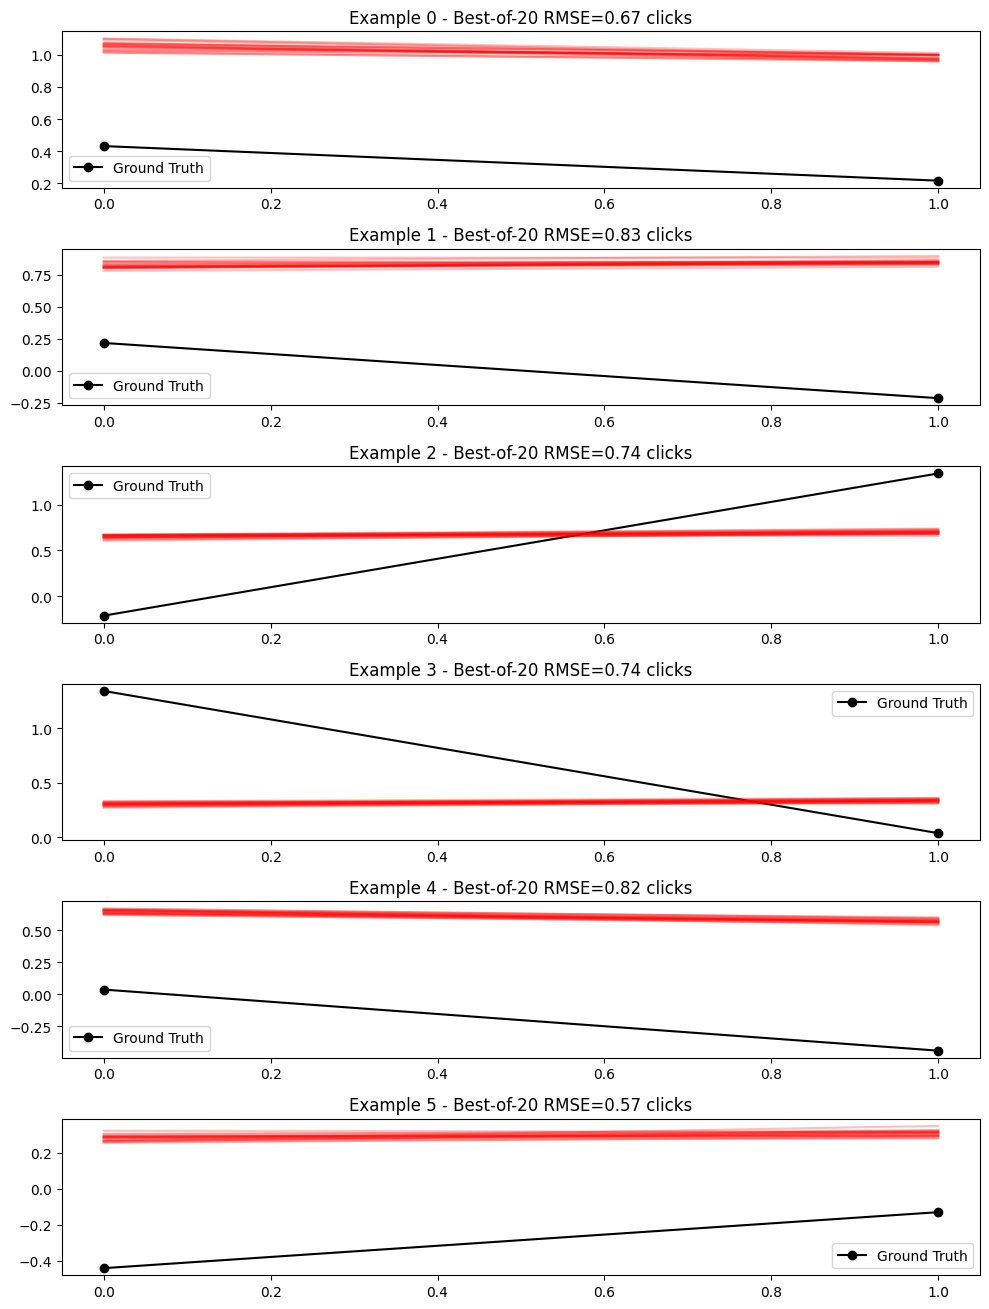

In [27]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Model / training hyperparams
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 30
HIDDEN_DIM = 64
LATENT_DIM = 16
PAST_WEEKS = 4
FUTURE_WEEKS = 2
BETA = 0.001  # weight for KLD
N_SAMPLES = 20  # generate N samples per input for diversity evaluation


def fill_weeks_for_student(df):
    sid = df['id_student'].iloc[0]
    df2 = df.set_index('week').reindex(all_weeks, fill_value=0).reset_index()
    df2['id_student'] = sid
    return df2


scaler_stats = {}
for col in features:
    mu = weekly_full[col].mean()
    sigma = weekly_full[col].std() + 1e-9
    scaler_stats[col] = (mu, sigma)
    weekly_full[col] = (weekly_full[col] - mu) / sigma

weekly_full = weekly_full.rename(columns={'id_student':'student_id'})


def build_sequences(df, past=PAST_WEEKS, future=FUTURE_WEEKS, feat_cols=features):
    sequences = []
    for sid, g in df.groupby('student_id'):
        g = g.sort_values('week').reset_index(drop=True)
        X = g[feat_cols].values  # shape [T, F]
        T = X.shape[0]
        window = past + future
        if T < window:
            continue
        for start in range(0, T - window + 1):
            enc = X[start:start+past]  # (past, F)
            tgt = X[start+past:start+past+future, 0]  # clicks only (standardized)
            sequences.append({'student_id':sid, 'encoder':enc.astype(np.float32), 'target':tgt.astype(np.float32)})
    return sequences

sequences = build_sequences(weekly_full)
print('Total sequences:', len(sequences))

student_ids = weekly_full['student_id'].unique()
train_ids, test_ids = train_test_split(student_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.125, random_state=42)

def filter_by_ids(seq_list, ids_set):
    return [s for s in seq_list if s['student_id'] in ids_set]

train_seq = filter_by_ids(sequences, set(train_ids))
val_seq = filter_by_ids(sequences, set(val_ids))
test_seq = filter_by_ids(sequences, set(test_ids))
print('Split sizes (train/val/test):', len(train_seq), len(val_seq), len(test_seq))

class SeqDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        item = self.seqs[idx]
        return torch.tensor(item['encoder'], dtype=torch.float32), torch.tensor(item['target'], dtype=torch.float32)

train_loader = DataLoader(SeqDataset(train_seq), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(SeqDataset(val_seq), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SeqDataset(test_seq), batch_size=BATCH_SIZE, shuffle=False)

class Seq2SeqVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, output_len=FUTURE_WEEKS):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_len = output_len

        # Encoder LSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder initial hidden from z
        self.z_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.z_to_cell = nn.Linear(latent_dim, hidden_dim)

        # Decoder LSTM consumes previous click scalar (1-d) each step
        self.decoder_cell = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.out_fc = nn.Linear(hidden_dim, 1)

    def encode(self, x):
        # x: [batch, past, input_dim]
        _, (h_n, c_n) = self.encoder(x)  # h_n: [num_layers, batch, hidden]
        h = h_n[-1]  # [batch, hidden]
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, teacher_forcing_y=None):
        # z: [batch, latent]
        batch = z.size(0)
        device = z.device
        h0 = torch.tanh(self.z_to_hidden(z)).unsqueeze(0)  # [1, batch, hidden]
        c0 = torch.tanh(self.z_to_cell(z)).unsqueeze(0)    # [1, batch, hidden]

        preds = []
        # start input: last observed click (we don't have it directly here; use zero initial scalar)
        dec_input = torch.zeros(batch, 1, 1, device=device)  # [batch, 1, 1]
        h, c = h0, c0
        for t in range(self.output_len):
            out, (h, c) = self.decoder_cell(dec_input, (h, c))  # out: [batch,1,hidden]
            pred = self.out_fc(out)  # [batch,1,1]
            preds.append(pred.squeeze(-1).squeeze(1))  # [batch]
            # next input: predicted scalar (detach to avoid backprop through sampling)
            dec_input = pred.detach()
        preds = torch.stack(preds, dim=1)  # [batch, output_len]
        return preds

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

mse_loss = nn.MSELoss(reduction='mean')
def vae_loss_fn(recon, target, mu, logvar, beta=BETA):
    # recon, target: [batch, future_len]
    recon_loss = mse_loss(recon, target)
    # KLD
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = recon_loss + beta * kld
    return loss, recon_loss.detach().item(), kld.detach().item()

# ---------------- instantiate ----------------
input_dim = len(features)
model = Seq2SeqVAE(input_dim=input_dim, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, output_len=FUTURE_WEEKS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ---------------- Training loop ----------------
best_val = 1e9
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    train_recon = 0.0
    train_kld = 0.0
    for X, y in tqdm(train_loader, desc=f"Train Epoch {epoch}/{EPOCHS}"):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar = model(X)
        loss, rloss, kld = vae_loss_fn(recon, y, mu, logvar, beta=BETA)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        train_recon += rloss * X.size(0)
        train_kld += kld * X.size(0)
    train_loss /= len(train_loader.dataset)
    train_recon /= len(train_loader.dataset)
    train_kld /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    val_recon = 0.0
    val_kld = 0.0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE); yv = yv.to(DEVICE)
            recon_v, mu_v, logvar_v = model(Xv)
            loss_v, rloss_v, kld_v = vae_loss_fn(recon_v, yv, mu_v, logvar_v, beta=BETA)
            val_loss += loss_v.item() * Xv.size(0)
            val_recon += rloss_v * Xv.size(0)
            val_kld += kld_v * Xv.size(0)
    val_loss /= len(val_loader.dataset)
    val_recon /= len(val_loader.dataset)
    val_kld /= len(val_loader.dataset)

    print(f"Epoch {epoch}: Train loss={train_loss:.4f} (recon={train_recon:.4f} kld={train_kld:.4f}) | Val loss={val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best_seq2seq_vae.pth')

# ---------------- Testing & Multi-sample Generation ----------------
model.load_state_dict(torch.load('best_seq2seq_vae.pth', map_location=DEVICE))
model.eval()

# We'll compute Best-of-N MSE, Diversity, Coverage across the entire test set
all_true = []
all_best_mse = []
all_diversity = []
all_coverage = []

with torch.no_grad():
    for Xtest, ytest in tqdm(test_loader, desc='Test generating'):
        Xtest = Xtest.to(DEVICE)
        ytest = ytest.to(DEVICE)  # [batch, future_len]
        batch = Xtest.size(0)
        mu, logvar = model.encode(Xtest)

        # generate N samples per instance by sampling different eps
        samples = []
        for n in range(N_SAMPLES):
            z = model.reparameterize(mu, logvar)  # uses random eps internally
            pred = model.decode(z)  # [batch, future_len]
            samples.append(pred.cpu().numpy())
        samples = np.stack(samples, axis=0)  # [N, batch, future_len]

        # metrics per element in batch
        for b in range(batch):
            true = ytest[b].cpu().numpy()  # [future_len]
            sims = samples[:, b, :]        # [N, future_len]
            # Best-of-N MSE
            mse_per_sample = np.mean((sims - true[np.newaxis, :])**2, axis=1)  # [N]
            best_mse = mse_per_sample.min()
            # Diversity: avg std across time steps
            diversity = np.mean(np.std(sims, axis=0))
            # Coverage: proportion of time steps where true is within [min,max] across samples
            lower = sims.min(axis=0)
            upper = sims.max(axis=0)
            covered = np.logical_and(true >= lower, true <= upper)
            coverage = covered.mean()
            all_true.append(true)
            all_best_mse.append(best_mse)
            all_diversity.append(diversity)
            all_coverage.append(coverage)

# aggregate
all_true = np.array(all_true)
mean_best_mse = float(np.mean(all_best_mse))
mean_diversity = float(np.mean(all_diversity))
mean_coverage = float(np.mean(all_coverage))

print(f"Test Best-of-{N_SAMPLES} MSE (standardized clicks) = {mean_best_mse:.4f}")
print(f"Mean Diversity (std on predictions) = {mean_diversity:.4f}")
print(f"Mean Coverage = {mean_coverage:.4f}")

# ---------------- Convert metrics to original clicks scale (for interpretability) ----------------
# Recall clicks were standardized: (clicks - mu)/sigma
clicks_mu, clicks_sigma = scaler_stats['clicks']
# If MSE is computed on standardized clicks, RMSE_std * sigma = RMSE in original units
rmse_std = np.sqrt(mean_best_mse)
rmse_original = rmse_std * clicks_sigma
print(f"Test Best-of-{N_SAMPLES} RMSE in original clicks = {rmse_original:.3f} clicks (avg per prediction step)")

# ---------------- Visualization: show a few test examples ----------------
# Visualize first few test instances (take first batch from test_loader)
X0, y0 = next(iter(test_loader))
with torch.no_grad():
    X0 = X0.to(DEVICE)
    mu0, logvar0 = model.encode(X0)
    samples_v = []
    for n in range(N_SAMPLES):
        z = model.reparameterize(mu0, logvar0)
        pred = model.decode(z)  # [batch, future]
        samples_v.append(pred.cpu().numpy())
samples_v = np.stack(samples_v, axis=0)  # [N, batch, future]

num_plots = min(6, X0.size(0))
plt.figure(figsize=(10, 2.2 * num_plots))
for i in range(num_plots):
    true_orig = y0[i].numpy() * clicks_sigma + clicks_mu
    plt.subplot(num_plots,1,i+1)
    plt.plot(range(FUTURE_WEEKS), true_orig, marker='o', label='Ground Truth', color='black')
    for n in range(N_SAMPLES):
        s = samples_v[n, i, :] * clicks_sigma + clicks_mu
        plt.plot(range(FUTURE_WEEKS), s, alpha=0.25, color='red')
    plt.title(f"Example {i} - Best-of-{N_SAMPLES} RMSE={(np.min(np.mean((samples_v[:,i,:]-y0[i].numpy())**2,axis=1))**0.5*clicks_sigma):.2f} clicks")
    plt.legend()
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 30 # 為了快速演示，可設為 10，建議 30
HIDDEN_DIM = 64
LATENT_DIM = 16
PAST_WEEKS = 4
FUTURE_WEEKS = 2
BETA = 0.001
N_SAMPLES = 20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('Device:', DEVICE)

studentInfo = pd.read_csv('/kaggle/input/student-demographics-online-education-dataoulad/studentInfo.csv')
studentVle = pd.read_csv('/kaggle/input/student-demographics-online-education-dataoulad/studentVle.csv')
studentAssessment = pd.read_csv('/kaggle/input/student-demographics-online-education-dataoulad/studentAssessment.csv')

studentVle['week'] = (studentVle['date'] // 7).astype(int)
studentAssessment['week'] = (studentAssessment['date_submitted'] // 7).astype(int)
clicks_weekly = studentVle.groupby(['id_student', 'week'])['sum_click'].sum().reset_index(name='clicks')
submit_weekly = studentAssessment.groupby(['id_student', 'week'])['score'].count().reset_index(name='submit_cnt')
score_avg = studentAssessment.groupby(['id_student', 'week'])['score'].mean().reset_index(name='avg_score_sofar')
weekly = clicks_weekly.merge(submit_weekly, on=['id_student', 'week'], how='left')
weekly = weekly.merge(score_avg, on=['id_student', 'week'], how='left')
weekly['submit_cnt'] = weekly['submit_cnt'].fillna(0).astype(int)
weekly['avg_score_sofar'] = weekly['avg_score_sofar'].fillna(0)
weekly['clicks_diff1'] = weekly.groupby('id_student')['clicks'].diff().fillna(0).astype(int)

all_weeks = range(weekly['week'].min(), weekly['week'].max() + 1)
def fill_weeks_for_student(df):
    sid = df['id_student'].iloc[0]
    df2 = df.set_index('week').reindex(all_weeks, fill_value=0).reset_index()
    df2['id_student'] = sid
    return df2

weekly_full = weekly.groupby('id_student', group_keys=False).apply(fill_weeks_for_student).reset_index(drop=True)
weekly_full = weekly_full[weekly_full['week'] >= 0]
features = ['clicks', 'submit_cnt', 'avg_score_sofar', 'clicks_diff1']

# 標準化
scaler_stats = {}
for col in features:
    mu = weekly_full[col].mean()
    sigma = weekly_full[col].std() + 1e-9
    scaler_stats[col] = (mu, sigma)
    weekly_full[col] = (weekly_full[col] - mu) / sigma

weekly_full = weekly_full.rename(columns={'id_student':'student_id'})

# 建立序列
def build_sequences(df, past=PAST_WEEKS, future=FUTURE_WEEKS, feat_cols=features):
    sequences = []
    for sid, g in df.groupby('student_id'):
        g = g.sort_values('week').reset_index(drop=True)
        X = g[feat_cols].values
        T = X.shape[0]
        window = past + future
        if T < window: continue
        for start in range(0, T - window + 1):
            enc = X[start:start+past]
            tgt = X[start+past:start+past+future, 0] # 只預測 clicks
            sequences.append({'student_id':sid, 'encoder':enc.astype(np.float32), 'target':tgt.astype(np.float32)})
    return sequences

sequences = build_sequences(weekly_full)
student_ids = weekly_full['student_id'].unique()
train_ids, test_ids = train_test_split(student_ids, test_size=0.2, random_state=SEED)
train_ids, val_ids = train_test_split(train_ids, test_size=0.125, random_state=SEED)

def filter_by_ids(seq_list, ids_set):
    return [s for s in seq_list if s['student_id'] in ids_set]

train_seq = filter_by_ids(sequences, set(train_ids))
val_seq = filter_by_ids(sequences, set(val_ids))
test_seq = filter_by_ids(sequences, set(test_ids))

class SeqDataset(Dataset):
    def __init__(self, seqs): self.seqs = seqs
    def __len__(self): return len(self.seqs)
    def __getitem__(self, idx):
        item = self.seqs[idx]
        return torch.tensor(item['encoder'], dtype=torch.float32), torch.tensor(item['target'], dtype=torch.float32)

train_loader = DataLoader(SeqDataset(train_seq), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SeqDataset(val_seq), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SeqDataset(test_seq), batch_size=BATCH_SIZE, shuffle=False)

# --- 2. 模型定義 ---

# VAE 模型 (與您提供的一致)
class Seq2SeqVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, output_len=FUTURE_WEEKS):
        super().__init__()
        self.output_len = output_len
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.z_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.z_to_cell = nn.Linear(latent_dim, hidden_dim)
        self.decoder_cell = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.out_fc = nn.Linear(hidden_dim, 1)

    def encode(self, x):
        _, (h_n, _) = self.encoder(x)
        h = h_n[-1]
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        batch, device = z.size(0), z.device
        h0 = torch.tanh(self.z_to_hidden(z)).unsqueeze(0)
        c0 = torch.tanh(self.z_to_cell(z)).unsqueeze(0)
        preds = []
        dec_input = torch.zeros(batch, 1, 1, device=device)
        h, c = h0, c0
        for t in range(self.output_len):
            out, (h, c) = self.decoder_cell(dec_input, (h, c))
            pred = self.out_fc(out)
            preds.append(pred.squeeze(-1).squeeze(1))
            dec_input = pred.detach()
        return torch.stack(preds, dim=1)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# LSTM 模型 (與您提供的一致，稍作修改以適應訓練循環)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim=len(features), hidden_dim=HIDDEN_DIM, output_len=FUTURE_WEEKS):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(1, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.output_len = output_len

    def forward(self, x):
        batch_size, device = x.size(0), x.device
        _, (h, c) = self.encoder(x)
        dec_input = torch.zeros(batch_size, 1, 1, device=device)
        outputs = []
        for t in range(self.output_len):
            out, (h, c) = self.decoder(dec_input, (h, c))
            pred = self.fc(out)
            outputs.append(pred)
            dec_input = pred.detach() # Inference
        return torch.cat(outputs, dim=1).squeeze(-1)


# --- 3. 訓練兩個模型 ---

# 訓練 VAE
print("\n--- Training Seq2Seq VAE ---")
vae_model = Seq2SeqVAE(input_dim=len(features)).to(DEVICE)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=LR)
mse_loss = nn.MSELoss(reduction='mean')

def vae_loss_fn(recon, target, mu, logvar, beta=BETA):
    recon_loss = mse_loss(recon, target)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld, recon_loss.detach().item()

best_val_loss_vae = float('inf')
for epoch in range(1, EPOCHS + 1):
    vae_model.train()
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        vae_optimizer.zero_grad()
        recon, mu, logvar = vae_model(X)
        loss, _ = vae_loss_fn(recon, y, mu, logvar)
        loss.backward()
        vae_optimizer.step()

    vae_model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(DEVICE), yv.to(DEVICE)
            recon_v, mu_v, logvar_v = vae_model(Xv)
            loss_v, _ = vae_loss_fn(recon_v, yv, mu_v, logvar_v)
            val_loss += loss_v.item() * Xv.size(0)
    val_loss /= len(val_loader.dataset)

    if (epoch % 10 == 0) or (epoch == EPOCHS):
        print(f"VAE Epoch {epoch}/{EPOCHS}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_vae:
        best_val_loss_vae = val_loss
        torch.save(vae_model.state_dict(), 'best_seq2seq_vae.pth')

# 訓練 LSTM
print("\n--- Training Seq2Seq LSTM ---")
lstm_model = Seq2SeqLSTM().to(DEVICE)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)
lstm_criterion = nn.MSELoss()

best_val_loss_lstm = float('inf')
for epoch in range(1, EPOCHS + 1):
    lstm_model.train()
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        lstm_optimizer.zero_grad()
        pred = lstm_model(X)
        loss = lstm_criterion(pred, y)
        loss.backward()
        lstm_optimizer.step()

    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(DEVICE), yv.to(DEVICE)
            pred_v = lstm_model(Xv)
            loss_v = lstm_criterion(pred_v, yv)
            val_loss += loss_v.item() * Xv.size(0)
    val_loss /= len(val_loader.dataset)

    if (epoch % 10 == 0) or (epoch == EPOCHS):
      print(f"LSTM Epoch {epoch}/{EPOCHS}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_lstm:
        best_val_loss_lstm = val_loss
        torch.save(lstm_model.state_dict(), 'best_seq2seq_lstm.pth')

# --- 4. 評估與生成比較表格 ---
print("\n--- Evaluating models and generating comparison table ---")

# 載入最佳模型
vae_model.load_state_dict(torch.load('best_seq2seq_vae.pth', map_location=DEVICE))
lstm_model.load_state_dict(torch.load('best_seq2seq_lstm.pth', map_location=DEVICE))
vae_model.eval()
lstm_model.eval()

# 點擊數的反標準化參數
clicks_mu, clicks_sigma = scaler_stats['clicks']

results = []
original_indices = test_loader.dataset.seqs # 取得原始序列的 reference

with torch.no_grad():
    for i, (Xtest, ytest) in enumerate(tqdm(test_loader, desc='Comparing on Test Set')):
        Xtest, ytest = Xtest.to(DEVICE), ytest.to(DEVICE)
        batch_size = Xtest.size(0)

        # 1. 取得 LSTM 預測
        y_pred_lstm = lstm_model(Xtest)

        # 2. 取得 VAE 多個樣本預測
        mu, logvar = vae_model.encode(Xtest)
        samples = []
        for _ in range(N_SAMPLES):
            z = vae_model.reparameterize(mu, logvar)
            pred = vae_model.decode(z)
            samples.append(pred)
        samples = torch.stack(samples, dim=0) # [N, batch, future_len]

        # 逐一樣本計算指標
        for b in range(batch_size):
            # 取得標準化後的真實值與預測值
            true_std = ytest[b]
            lstm_pred_std = y_pred_lstm[b]
            vae_samples_std = samples[:, b, :] # [N, future_len]

            # 反標準化
            true_orig = true_std.cpu().numpy() * clicks_sigma + clicks_mu
            lstm_pred_orig = lstm_pred_std.cpu().numpy() * clicks_sigma + clicks_mu
            vae_samples_orig = vae_samples_std.cpu().numpy() * clicks_sigma + clicks_mu

            # 計算 LSTM MSE (在原始尺度上)
            lstm_mse = np.mean((lstm_pred_orig - true_orig)**2)

            # 計算 VAE Best-of-N MSE (在原始尺度上)
            mse_per_sample = np.mean((vae_samples_orig - true_orig[np.newaxis, :])**2, axis=1)
            best_mse_idx = np.argmin(mse_per_sample)
            vae_best_mse = mse_per_sample[best_mse_idx]
            vae_best_pred_orig = vae_samples_orig[best_mse_idx]

            # 計算 VAE Diversity (在原始尺度上)
            diversity_std = np.mean(np.std(vae_samples_orig, axis=0))

            # 取得原始資料索引
            original_idx = i * BATCH_SIZE + b

            results.append({
                'idx': original_idx,
                'LSTM_MSE': lstm_mse,
                'VAE_best_MSE': vae_best_mse,
                'd(LSTM-VAE)': lstm_mse - vae_best_mse,
                'y_true': true_orig,
                'y_LSTM': lstm_pred_orig,
                'y_VAE_best': vae_best_pred_orig,
                'Diversity_std': diversity_std
            })

# 轉換為 DataFrame 並排序
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='d(LSTM-VAE)', ascending=False).reset_index(drop=True)

# 格式化輸出
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
print("\n=== Top-5 Regressed (VAE best >> LSTM) ===")
display(results_df_sorted.head(5))

Device: cuda


/tmp/ipython-input-1216216188.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_full = weekly.groupby('id_student', group_keys=False).apply(fill_weeks_for_student).reset_index(drop=True)



--- Training Seq2Seq VAE ---
VAE Epoch 10/30, Val Loss: 0.6614
VAE Epoch 20/30, Val Loss: 0.6772
VAE Epoch 30/30, Val Loss: 0.6799

--- Training Seq2Seq LSTM ---
LSTM Epoch 10/30, Val Loss: 0.6634
LSTM Epoch 20/30, Val Loss: 0.6751
LSTM Epoch 30/30, Val Loss: 0.6864

--- Evaluating models and generating comparison table ---


Comparing on Test Set: 100%|██████████| 1386/1386 [01:07<00:00, 20.41it/s]



=== Top-5 Regressed (VAE best >> LSTM) ===


,idx,LSTM_MSE,VAE_best_MSE,d(LSTM-VAE),y_true,y_LSTM,y_VAE_best,Diversity_std
0,140097,1195632.759637,969803.132630,225829.627008,"[1533.9999485182466, 1610.9999485182466]","[538.0370578932467, 428.0699253248873]","[694.9848117994967, 499.3975620436373]",4.047153
1,164169,1773276.692592,1571332.422342,201944.270250,"[1790.000070588559, 1721.9999485182466]","[501.8880100416842, 348.20203592059045]","[592.1806125807467, 415.13599588152795]",9.639763
2,164168,1441531.840012,1244351.005075,197180.834937,"[1068.9999485182466, 1790.000070588559]","[341.44275857684045, 255.8148746657076]","[445.9383030104342, 340.6912021803561]",7.623533
3,164170,616639.439364,483830.953719,132808.485645,"[1721.9999485182466, 603.000009553403]","[623.5976047682467, 439.3199253248873]","[742.735605256528, 509.7087803053561]",4.601594
4,140098,443602.209288,338146.484588,105455.724700,"[1610.9999485182466, 573.000009553403]","[672.7241916823092, 490.2774448561373]","[789.1807956862154, 542.8960361647311]",1.881926
